# CycleGAN training loop

> Defines the loss and training loop functions/classes for CycleGAN.

In [ ]:
#default_exp train.cyclegan

In [ ]:
#export
from fastai.vision.all import *
from fastai.basics import *
from typing import List
from fastai.vision.gan import *
from upit.models.cyclegan import *
from upit.data.unpaired import *

In [ ]:
#hide
from nbdev.showdoc import *

## The Loss Function


Let's start out by writing the loss function for the CycleGAN model.
The main loss used to train the generators. It has three parts:
- the classic GAN loss: they must make the discriminator believe their images are real.
- identity loss: if they are given an image from the domain they are trying to imitate, they should return the same thing
- cycle loss: if an image from domain A goes through the generator that imitates domain B then through the generator that imitates domain A, it should be reconstructed as the same initial image. Same for domain B and switching the generators

In [ ]:
#export
class CycleGANLoss(nn.Module):
    """
    CycleGAN loss function. The individual loss terms are also atrributes of this class that are accessed by fastai for recording during training.
    
    Attributes: \n
    `self.cgan` (`nn.Module`): The CycleGAN model. \n
    `self.l_A` (`float`): lambda_A, weight of domain A losses. \n
    `self.l_B` (`float`): lambda_B, weight of domain B losses. \n
    `self.l_idt` (`float`): lambda_idt, weight of identity lossees. \n
    `self.crit` (`AdaptiveLoss`): The adversarial loss function (either a BCE or MSE loss depending on `lsgan` argument) \n
    `self.real_A` and `self.real_B` (`fastai.torch_core.TensorImage`): Real images from domain A and B. \n
    `self.id_loss_A` (`torch.FloatTensor`): The identity loss for domain A calculated in the forward function \n
    `self.id_loss_B` (`torch.FloatTensor`): The identity loss for domain B calculated in the forward function \n
    `self.gen_loss` (`torch.FloatTensor`): The generator loss calculated in the forward function \n
    `self.cyc_loss` (`torch.FloatTensor`): The cyclic loss calculated in the forward function 
    """
    
    
    def _create_gan_loss(self, loss_func):
        """
        Create adversarial loss function. It takes in an existing loss function (like those from torch.nn.functional), and returns a 
        loss function that allows comparison between discriminator output feature map, and single values (0 or 1 for real and fake)
        """
        def gan_loss_func(output, target):
            return loss_func(output, torch.Tensor([target]).expand_as(output).to(output.device))
        return gan_loss_func
    
    
    def __init__(self, cgan:nn.Module, l_A:float=10., l_B:float=10, l_idt:float=0.5, lsgan:bool=True):
        """
        Constructor for CycleGAN loss.
        
        Arguments:
        
        `cgan` (`nn.Module`): The CycleGAN model. \n
        `l_A` (`float`): weight of domain A losses. (default=10) \n
        `l_B` (`float`): weight of domain B losses. (default=10) \n
        `l_idt` (`float`): weight of identity losses. (default=0.5) \n
        `lsgan` (`bool`): Whether or not to use LSGAN objective. (default=True)
        """
        super().__init__()
        store_attr(self,'cgan,l_A,l_B,l_idt,lsgan')
        self.crit = self._create_gan_loss(F.mse_loss if self.lsgan else F.binary_cross_entropy)
        
    def set_input(self, input): "set `self.real_A` and `self.real_B` for future loss calculation"; self.real_A,self.real_B = input
    
    def forward(self, output, target, discriminator=False):
        """
        Forward function of the CycleGAN loss function. The generated images are passed in as output (which comes from the model)
        and the generator loss is returned. If `discriminator` is set to True, the discriminator adversarial loss will be calculated 
        and returned instead.
        """  
        if discriminator: #if discriminator argument is True, calculate and return the adversarial discriminator 
            fake_A, fake_B = output
            real_A, real_B = target
            self.D_A_loss = 0.5 * (self.crit(self.cgan.D_A(real_A), 1) + self.crit(self.cgan.D_A(fake_A), 0))
            self.D_B_loss = 0.5 * (self.crit(self.cgan.D_B(real_B), 1) + self.crit(self.cgan.D_B(fake_B), 0))
            return self.D_A_loss, self.D_B_loss
        
        fake_A, fake_B, idt_A, idt_B = output
        #Generators should return identity on the datasets they try to convert to
        self.id_loss_A = self.l_idt * self.l_A * F.l1_loss(idt_A, self.real_A)
        self.id_loss_B = self.l_idt * self.l_B * F.l1_loss(idt_B, self.real_B)
        #Generators are trained to trick the discriminators so the following should be ones
        self.gen_loss_A = self.crit(self.cgan.D_A(fake_A), 1) 
        self.gen_loss_B = self.crit(self.cgan.D_B(fake_B), 1)
        #Cycle loss
        self.cyc_loss_A = self.l_A * F.l1_loss(self.cgan.G_A(fake_B), self.real_A)
        self.cyc_loss_B = self.l_B * F.l1_loss(self.cgan.G_B(fake_A), self.real_B)
        return self.id_loss_A+self.id_loss_B+self.gen_loss_A+self.gen_loss_B+self.cyc_loss_A+self.cyc_loss_B

In [ ]:
show_doc(CycleGANLoss.__init__)

<h4 id="CycleGANLoss.__init__" class="doc_header"><code>CycleGANLoss.__init__</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>CycleGANLoss.__init__</code>(**`cgan`**:`Module`, **`l_A`**:`float`=*`10.0`*, **`l_B`**:`float`=*`10`*, **`l_idt`**:`float`=*`0.5`*, **`lsgan`**:`bool`=*`True`*)

Constructor for CycleGAN loss.

Arguments:

`cgan` (`nn.Module`): The CycleGAN model. 

`l_A` (`float`): weight of domain A losses. (default=10) 

`l_B` (`float`): weight of domain B losses. (default=10) 

`l_idt` (`float`): weight of identity losses. (default=0.5) 

`lsgan` (`bool`): Whether or not to use LSGAN objective. (default=True)

In [ ]:
show_doc(CycleGANLoss.set_input)

<h4 id="CycleGANLoss.set_input" class="doc_header"><code>CycleGANLoss.set_input</code><a href="__main__.py#L46" class="source_link" style="float:right">[source]</a></h4>

> <code>CycleGANLoss.set_input</code>(**`input`**)

set `self.real_A` and `self.real_B` for future loss calculation

In [ ]:
show_doc(CycleGANLoss.forward)

<h4 id="CycleGANLoss.forward" class="doc_header"><code>CycleGANLoss.forward</code><a href="__main__.py#L48" class="source_link" style="float:right">[source]</a></h4>

> <code>CycleGANLoss.forward</code>(**`output`**, **`target`**, **`discriminator`**=*`False`*)

Forward function of the CycleGAN loss function. The generated images are passed in as output (which comes from the model)
and the generator loss is returned. If [`discriminator`](/UPITmodels.cyclegan#discriminator) is set to True, the discriminator adversarial loss will be calculated 
and returned instead.

## Training loop callback
Let's now write the main callback to train a CycleGAN model. 

Fastai's callback system is very flexible, allowing us to adjust the traditional training loop in any conceivable way possible. Let's use it for GAN training.

We have the `_set_trainable` function that is called with arguments telling which networks need to be put in training mode or which need to be frozen.

When we start training `before_train`, we define separate optimizers. `self.opt_G` for the generators and `self.opt_D` for the discriminators. Then we put the generators in training mode (with `_set_trainable`).

Before passing the batch into the model (`before_batch`), we have to fix it since the domain B image was kept as the target, but it also needs to be passed into the model. We also set the inputs for the loss function.

In `after_batch`, we calculate the discriminator losses, backpropagate, and update the weights of both the discriminators. The main training loop will train the generators (so `learn.opt` is given those parameters).

In [ ]:
#export
class CycleGANTrainer(Callback):
    """`Learner` Callback for training a CycleGAN model."""
    run_before = Recorder
    
    def __init__(self): pass
    
    def _set_trainable(self, disc=False):
        """Put the generators or discriminators in training mode depending on arguments."""
        def set_requires_grad(m, rg): 
            for p in m.parameters(): p.requires_grad_(rg) 
        set_requires_grad(self.learn.model.G_A, not disc)
        set_requires_grad(self.learn.model.G_B, not disc)
        set_requires_grad(self.learn.model.D_A, disc)
        set_requires_grad(self.learn.model.D_B, disc)
        if disc: self.opt_D.hypers = self.learn.opt.hypers
            
    def before_train(self, **kwargs):
        #Setup and define optimizers for generator and discriminator
        self.G_A,self.G_B = self.learn.model.G_A,self.learn.model.G_B
        self.D_A,self.D_B = self.learn.model.D_A,self.learn.model.D_B
        self.crit = self.learn.loss_func.crit
        if not getattr(self,'opt_G',None):
            self.opt_G = self.learn.opt_func(self.learn.splitter(nn.Sequential(*flatten_model(self.G_A), *flatten_model(self.G_B))), self.learn.lr)
        else: 
            self.opt_G.hypers = self.learn.opt.hypers
        if not getattr(self,'opt_D',None):
            self.opt_D = self.learn.opt_func(self.learn.splitter(nn.Sequential(*flatten_model(self.D_A), *flatten_model(self.D_B))), self.learn.lr)

        self.learn.opt = self.opt_G
        self._set_trainable()
        
    def before_batch(self, **kwargs):
        #Reorganize the input batch
        self._training = self.learn.model.training
        self.learn.xb = (self.learn.xb[0],self.learn.yb[0]),
        self.learn.loss_func.set_input(*self.learn.xb)

    def after_step(self): self.opt_D.hypers = self.learn.opt.hypers

    def after_batch(self, **kwargs):
        # Discriminator training loop
        self.G_A.zero_grad(); self.G_B.zero_grad()
        fake_A, fake_B = self.learn.pred[0].detach(), self.learn.pred[1].detach() 
        (real_A, real_B), = self.learn.xb
        if self._training:
            self._set_trainable(True)
            self.D_A.zero_grad(); self.D_B.zero_grad()
            loss_D_A, loss_D_B = self.learn.loss_func((fake_A,fake_B),(real_A,real_B),discriminator=True)
            loss_D_A.backward()
            loss_D_B.backward()
            self.opt_D.step()
            self._set_trainable()
    
    def before_validate(self, **kwargs):
        self.G_A,self.G_B = self.learn.model.G_A,self.learn.model.G_B
        self.D_A,self.D_B = self.learn.model.D_A,self.learn.model.D_B
        self.crit = self.learn.loss_func.crit

In [ ]:
#export
class AvgMetric(Metric):
    """
    Average the values of `func` taking into account potential different batch sizes. 
    Overwrites fastai's version by including argument to decode the output image
    """
    def __init__(self, func, decode=True):  
        self.func = func
        self.decode = denorm
    def reset(self): self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        args = [*learn.xb[0], *learn.pred, *learn.yb]
        if self.decode: args = [learn.dls.after_batch.decode(TensorImage(b)).float() for b in args]
        self.total += to_detach(self.func(*args))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__

## CycleGAN LR scheduler

The original CycleGAN paper started with a period of constant learning rate and a period of linearly decaying learning rate. Let's make a scheduler to implement this (with other possibilities as well). Fastai already comes with many types of hyperparameter schedules, and new ones can be created by combining existing ones. Let's see how to do this:

In [ ]:
#export
def combined_flat_anneal(pct:float, start_lr:float, end_lr:float=0, curve_type:str='linear'):
    """
    Create a schedule with constant learning rate `start_lr` for `pct` proportion of the training, and a `curve_type` learning rate (till `end_lr`) for remaining portion of training.
    
    Arguments:
    `pct` (`float`): Proportion of training with a constant learning rate.
    
    `start_lr` (`float`): Desired starting learning rate, used for beginnning `pct` of training.
    
    `end_lr` (`float`): Desired end learning rate, training will conclude at this learning rate.
    
    `curve_type` (`str`): Curve type for learning rate annealing. Options are 'linear', 'cosine', and 'exponential'.
    """
    if curve_type == 'linear':      SchedAnneal = SchedLin
    if curve_type == 'cosine':      SchedAnneal = SchedCos
    if curve_type == 'exponential': SchedAnneal = SchedExp
    schedule = combine_scheds([pct,1-pct],[SchedNo(start_lr,start_lr),SchedAnneal(start_lr,end_lr)])
    return schedule

Text(0.5,1,'Constant+annealing LR schedules')

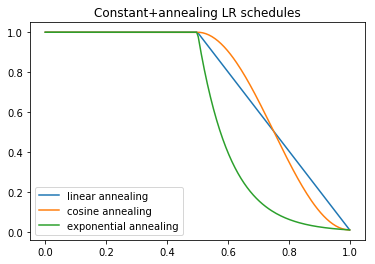

In [ ]:
p = torch.linspace(0.,1,200)
plt.plot(p, [combined_flat_anneal(0.5,1,1e-2,curve_type='linear')(o) for o in p],label = 'linear annealing')
plt.plot(p, [combined_flat_anneal(0.5,1,1e-2,curve_type='cosine')(o) for o in p],label = 'cosine annealing')
plt.plot(p, [combined_flat_anneal(0.5,1,1e-2,curve_type='exponential')(o) for o in p],label = 'exponential annealing')
plt.legend()
plt.title('Constant+annealing LR schedules')

Now that we have the learning rate schedule, we can write a quick training function that can be added as a method to `Learner` using `@patch` decorator. Function is inspired by [this code](https://github.com/fastai/fastai/blob/master/fastai/callback/schedule.py).

In [ ]:
#export
@patch
def fit_flat_lin(self:Learner, n_epochs:int=100, n_epochs_decay:int=100, start_lr:float=None, end_lr:float=0, curve_type:str='linear', wd:float=None,
                 cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` at flat `start_lr` before `curve_type` annealing to `end_lr` with weight decay of `wd` and callbacks `cbs`."
    total_epochs = n_epochs+n_epochs_decay
    pct_start = n_epochs/total_epochs
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if start_lr is None else start_lr)
    start_lr = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_flat_anneal(pct_start, start_lr, end_lr, curve_type)}
    self.fit(total_epochs, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [ ]:
from fastai.test_utils import *

In [ ]:
learn = synth_learner()
learn.fit_flat_lin(n_epochs=2,n_epochs_decay=2)

epoch,train_loss,valid_loss,time
0,6.763257,5.973986,00:00
1,6.041855,4.450920,00:00
2,5.236164,3.412698,00:00
3,4.606007,3.090190,00:00


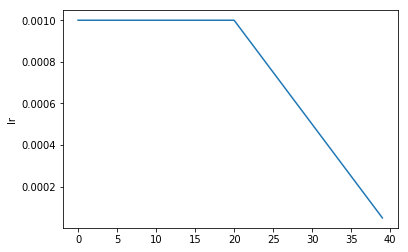

In [ ]:
learn.recorder.plot_sched()

## CycleGAN Learner construction

Below, we now define a method for initializing a `Learner` with the CycleGAN model and training callback.

In [ ]:
#export
@delegates(Learner.__init__)
def cycle_learner(dls:DataLoader, m:CycleGAN, opt_func=Adam, metrics:list=[], cbs:list=[], **kwargs):
    """
    Initialize and return a `Learner` object with the data in `dls`, CycleGAN model `m`, optimizer function `opt_func`, metrics `metrics`,
    and callbacks `cbs`. Other `Learner` arguments can be passed as well.
    """
    lms = LossMetrics(['id_loss_A', 'id_loss_B','gen_loss_A','gen_loss_B','cyc_loss_A','cyc_loss_B', 
                       'D_A_loss', 'D_B_loss'])

    learn = Learner(dls, m, loss_func=CycleGANLoss(m), opt_func=opt_func,
                    cbs=[CycleGANTrainer, *cbs],metrics=[*lms, *[AvgMetric(metric) for metric in [*metrics]]])

    learn.recorder.train_metrics = True
    learn.recorder.valid_metrics = False
    return learn

## Quick Test

In [ ]:
horse2zebra = untar_data('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip')

In [ ]:
folders = horse2zebra.ls().sorted()

In [ ]:
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]

In [ ]:
dls = get_dls(trainA_path, trainB_path)

In [ ]:
cycle_gan = CycleGAN(3,3,64)
learn = cycle_learner(dls, cycle_gan)

In [ ]:
test_eq(type(learn),Learner)

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=7.585775892948732e-05)

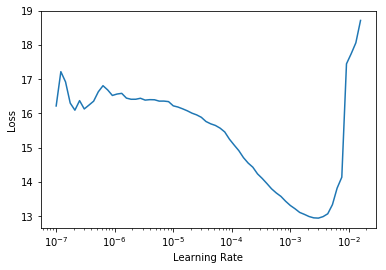

In [ ]:
#cuda
learn.lr_find()

In [ ]:
#cuda
learn.fit_flat_lin(1,1,2e-4)

epoch,train_loss,id_loss_A,id_loss_B,gen_loss_A,gen_loss_B,cyc_loss_A,cyc_loss_B,D_A_loss,D_B_loss,time
0,6.651612,1.136863,1.146853,0.598896,0.299569,2.403009,2.499691,0.403220,0.249888,03:02
1,5.545041,0.867873,0.809700,0.360292,0.336007,1.827404,1.756618,0.212341,0.214775,03:03


/home/tmabraham/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


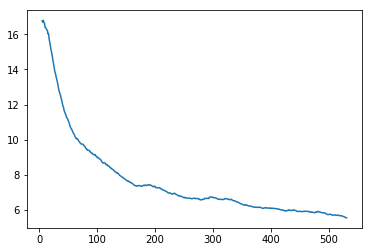

In [ ]:
#cuda
learn.recorder.plot_loss(with_valid=False)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_models.cyclegan.ipynb.
Converted 01b_models.junyanz.ipynb.
Converted 02_data.unpaired.ipynb.
Converted 03_train.cyclegan.ipynb.
Converted 04_inference.cyclegan.ipynb.
Converted index.ipynb.
